In [1]:
import pandas as pd 
import numpy as np
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.model_selection
import sklearn.cluster

from matplotlib import pyplot as plt
import py2neo
import seaborn as sb ##includes convenient heatmaps and boxplots
import scipy as sp
import pylab as pl

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Query Database

In [2]:
def query_database(query):
    # REMEMBER TO BE CONNECTED TO IMPERIAL WIFI!
    graph_db = py2neo.Graph("https://dsi-bitcoin.doc.ic.ac.uk:7473/db/data/", auth=("guest_ro", "imperialO_nly"))
    return graph_db.run(query)

def get_block_data(first_block, last_block):
    query_string = """
                    MATCH (b:Block) <-[:MINED_IN]- (t:Tx) <-[:IN]- (txi:TxIn) <-[:UNLOCK]- (iadr:Address)
                    WHERE b.height >= {} AND b.height <= {}
                    MATCH (txi) <-[:SPENT]- (txo_in:TxOut) 
                    MATCH (oadr:Address) <-[:LOCK]- (txo_out:TxOut) <-[:OUT]- (t)
                    
                    RETURN iadr.address as iadr, oadr.address as oadr, txo_in.value as input_val, txo_out.value as output_val, ID(txo_in) as id_txo_in, ID(txi) as id_txi, ID(t) as id_t, ID(txo_out) as id_txo_out
                    """.format(first_block, last_block)
    return query_string

def write_to_csv(result,string):

    df = result.to_data_frame()

    if (df.empty):
        print("Something went wrong, there is no data for this/these blocks")
    else:
        df.to_csv('{}.csv'.format(string), encoding='utf-8', index=False)


In [3]:
result = query_database(get_block_data(400000,400000))
df = result.to_data_frame()

In [11]:
#Check if any columns are unique
for column in df:
    print(df[column].is_unique)

False
False
False
False
False
False
False
False


In [ ]:
print(df['oadr'].value_counts().sort_values(ascending=False))
df1 = df.loc[df['iadr'] == '1BQLNJtMDKmMZ4PyqVFfRuBNvoGhjigBKF']

In [20]:
#Counting the number of shared input addresses per transaction

tx_ids = []
    
for val in df.id_t.value_counts().iteritems():
    tx_ids.append(val[0])

def iadrs_from_tx(id_t):
    return list(df['iadr'][df["id_t"] == id_t])


for t in tx_ids:
    dummy = iadrs_from_tx(t)
    print (t)
    break
    
from collections import Counter
Counter(dummy)
    

113001531


In [24]:
from collections import Counter
Counter(dummy)

Counter({'13Z7gwb97jn9KqJmsuP4BWboA2Cca7BdvQ': 21,
         '14JxkcG26Wg4SVkGpBqoRixeyKrDBrUWr6': 21,
         '14PwrKiRiVUuFwhDtCnpikqNts8VRuwMTq': 21,
         '14tFbsTd5S1kfGyPQNoXayCWGpArGaFiQS': 21,
         '15ZGoHSJQFcnepd1APyJ8heA261BBczGYK': 21,
         '15fr7RhRZZvDhNnKmAwrWm4CvedokVPipJ': 21,
         '17NqNwYgd1qi1wx35F7WanFzvGUSnqBchr': 21,
         '17dSWpnVcfEGoGYGw4vhFk4Spq4raSX8uz': 21,
         '18MJVg1TL9tWuH2JuepmNbpjZxbUqmmx22': 21,
         '19L9UgQPZjan8fxf3UKZAv9mTFsJ24u1Vu': 21,
         '19Tr6aAoE6Pnw2MHB5VnZvfSH2eacxmtwP': 21,
         '1E3R1SmvEH8hDMZBCfvgqW5DqLcHi5V131': 21,
         '1E63pMoZBPvc9evyPGcCSQHRjVTp37gKqN': 21,
         '1EUStGZrnY7eaMUGo55yQKM7icgvLNa5ta': 21,
         '1F7ipHVRsvxjjYDWHFhnALeuw1k516BqNA': 21,
         '1J2rB3fJaPz9cG9J7tPLmtgdLezNjBCHXi': 21,
         '1JQSc3mQNUrArHi3ZqL77nAhj7MkVBYMDM': 21,
         '1JqGgDpyzrpmToRmR8V7RSWq65YKyFwVbS': 21,
         '1KLPf92poJPSkw6cmScTaK8LgzPXFWBV1V': 21,
         '1KszGa1D78hH5fFF9L9LY

# CLUSTERING

/homes/ac2917/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


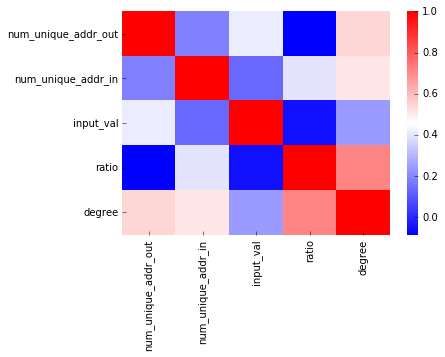

In [27]:
cluster = (
    df.groupby('id_t')
    .agg({
        'input_val': 'sum',
        'id_txi': 'nunique',
        'id_txo_out': 'nunique',
        'iadr': 'nunique',
        'oadr': 'nunique',       
    }).rename(columns = {
        'iadr':'num_unique_addr_in',
        'oadr':'num_unique_addr_out'
    })
)

cluster['ratio'] = cluster['id_txi'] / cluster['id_txo_out']
cluster['degree'] = cluster['id_txi'] + cluster['id_txo_out'] 

cluster = cluster.drop(columns=['id_txi', 'id_txo_out'])

#Normalize data

scaler = sklearn.preprocessing.StandardScaler()
scaled_cluster = scaler.fit_transform(cluster)
cluster_scaled = pd.DataFrame(scaled_cluster, columns=cluster.columns, index=cluster.index)


data_corr = cluster_scaled.corr()
sb.heatmap(data_corr, cmap = 'bwr') #heatmap of correlation matrix

## K Means 

<function matplotlib.pyplot.show(*args, **kw)>

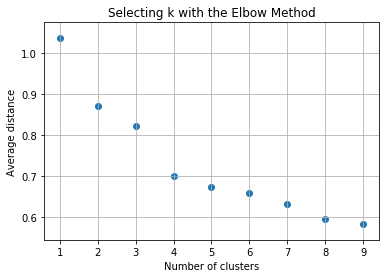

In [15]:
#split data into train and test sets
clus_train, clus_test = sklearn.model_selection.train_test_split(cluster_scaled, test_size=0.3, random_state=123)

clusters = range(1,10)
meandist=[]

for k in clusters:
    model = sklearn.cluster.KMeans(n_clusters = k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(clus_train,model.cluster_centers_,'euclidean'),axis=1))/clus_train.shape[0])
    
plt.scatter(clusters, meandist)
#plt.subplot(2,1,1)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show

# # Convert DataFrame to matrix
# mat = cluster_scaled.values
# distorsions = []
# x = range(2, 20)
# for k in x:
#     #Perform K Means
#     kmeans = sk.cluster.KMeans(n_clusters=k)
#     kmeans.fit(mat)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(x, distorsions)
# plt.grid(True)
# plt.title('Elbow curve')
# plt.show
# plt.xticks(x)

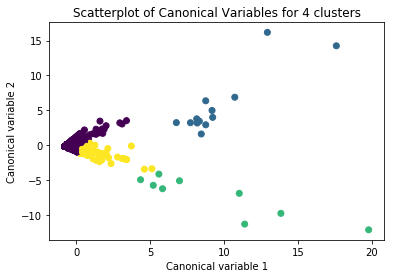

In [18]:
model = sklearn.cluster.KMeans(n_clusters = 4)
model.fit(clus_train)
clusassign = model.predict(clus_train)


#Principal Component Analysis
pca_2 = sklearn.decomposition.PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1],c=model.labels_)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 clusters')
plt.show

# Get cluster assignment labels
labels = model.labels_
# Format results as a DataFrame
data = {'transaction_id':clus_train.index,'cluster_label':labels}
results = pd.DataFrame(data)

# Determining statistics of inputs, outputs of a transaction

In [25]:
tx_ids = []
tx_id_val = []
txo_in_ids = []
txo_out_ids = []
iadr = []
oadr = []
txi_ids = []


for val in df.iadr.value_counts().iteritems():
    iadr.append(val[0])

for val in df.id_txi.value_counts().iteritems():
    txi_ids.append(val[0])
    
    
for val in df.oadr.value_counts().iteritems():
    oadr.append(val[0])
    
for val in df.id_t.value_counts().iteritems():
    tx_ids.append(val[0])
    data = df[df.id_t==val[0]]
    tx_id_val.append(data.output_val.sum())
    

for val in df.id_txo_in.value_counts().iteritems():
    txo_in_ids.append(val[0])
    
for val in df.id_txo_out.value_counts().iteritems():
    txo_out_ids.append(val[0])

In [ ]:
print(len(txo_in_ids))
print(len(txi_ids))
print(len(tx_ids))
print(len(txo_out_ids))

In [ ]:
matches = set(txo_in_ids).intersection(txo_out_ids)
print(len(matches))

In [26]:
print(len(iadr))
print(len(oadr))

3816
3430


In [ ]:
matches = set(iadr).intersection(oadr)
len(matches)